In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
import statsmodels.api as sm
import os 
import numpy as np

In [2]:
submissions_cleaned_df= pd.read_csv('submissions_cleaned_linked.csv')
comments_cleaned_df = pd.read_csv('comments_cleaned_linked.csv')


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


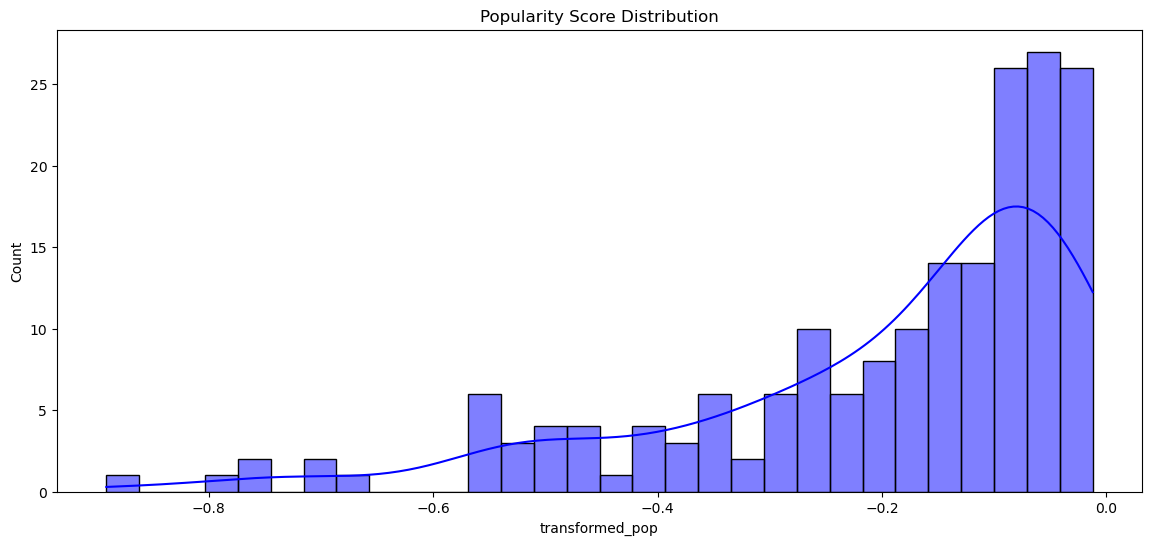

In [3]:
#histograms of popularity scores 

plt.figure(figsize=(14, 6))
submissions_cleaned_df['transformed_pop'] = np.log(submissions_cleaned_df['pop_score'])



sns.histplot(submissions_cleaned_df['transformed_pop'], bins=30, kde=True, color='blue')
plt.title('Popularity Score Distribution')
plt.show()

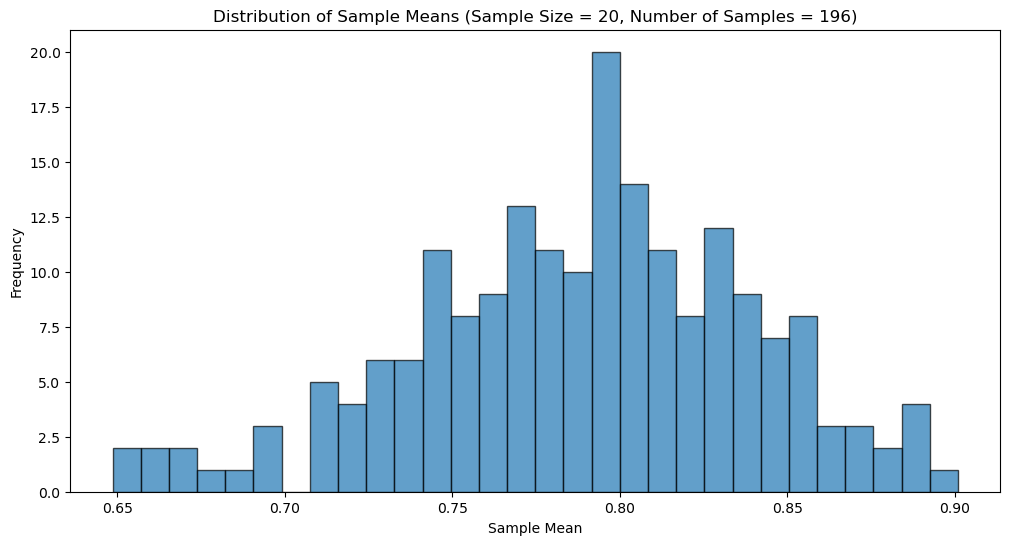

In [4]:
#apply CLT to hopefully get a more normal distribution of pop_scores

sample_size = 20 
num_samples = submissions_cleaned_df.shape[0]

def applyCLT(data, sample_size, num_samples):
    sample_means = []
    for _ in range(num_samples):  #iterate through the number of samples you want to take 
        sample = data.sample(n=sample_size, replace=True) #take a sample of size smaple_size 
        sample_means.append(sample.mean())   #add the mean of that sample top the sample_means list 
    return sample_means


sample_means = applyCLT(submissions_cleaned_df['pop_score'], sample_size, num_samples)
submissions_cleaned_df['pop_score_CLT'] = sample_means

plt.figure(figsize=(12, 6))
plt.hist(sample_means, bins=30, edgecolor='k', alpha=0.7)
plt.title(f'Distribution of Sample Means (Sample Size = {sample_size}, Number of Samples = {num_samples})')
plt.xlabel('Sample Mean')
plt.ylabel('Frequency')
plt.show()
#result: more normal looking !

In [5]:

positive_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] >= 0.5]['pop_score']
neutral_submissions= (submissions_cleaned_df['sentiment_score'] > -0.5) & (submissions_cleaned_df['sentiment_score'] < 0.5)
neutral_popularity = submissions_cleaned_df.loc[neutral_submissions, 'pop_score']
negative_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] <=-0.5 ]['pop_score']

#we can assume normally distributed data based on teh number of samples here 

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)
#slightly better but not that much better than the popularity score based on the upvotes-downvotes(they are essentially the same)


Number of positive samples: 21
Number of neutral samples: 139
Number of negative samples: 36



Result of ANOVA test: 

 The p value is: 
0.9596398515792344


In [6]:
subreddit_groups = [submissions_cleaned_df[submissions_cleaned_df['subreddit'] == sub]['sentiment_score']
                     for sub in submissions_cleaned_df['subreddit'].unique()]
anova_result = stats.f_oneway(*subreddit_groups)
print("ANOVA Result:", anova_result)                            

ANOVA Result: F_onewayResult(statistic=0.6099667444148007, pvalue=0.43575232213261184)


In [7]:
#how does the sentiment score of submissions vary across differnt comment counts? 
bins = [0, 10, 100, 300,500, 750, 1000, 1500, submissions_cleaned_df['num_comments'].max()] #max for this dataframe is ~1600
labels = ['0-10', '11-100', '101-300','301-500', '501-750', '751-1000','1001-1500', '1501+']
submissions_cleaned_df['comment_bin'] = pd.cut(submissions_cleaned_df['num_comments'], bins=bins, labels=labels)


#for each bin in the labels, filter the datframe to include the rows where comment_bin = bin label

comment_bins = [submissions_cleaned_df[submissions_cleaned_df['comment_bin'] == bin]['sentiment_score'] # then get the sentiment score 
                for bin in labels]
anova_result = stats.f_oneway(*comment_bins) 

print("ANOVA Result:", anova_result)



ANOVA Result: F_onewayResult(statistic=1.0887760181262645, pvalue=0.3723086444951319)


In [8]:
comments_cleaned_df.columns

Index(['link_id', 'body', 'score', 'sentiment_score', 'sentiment_rounded'], dtype='object')

In [9]:
# is there a reslationship between the score of comments and the sentiment of comments? 

comments_cleaned_df = comments_cleaned_df.dropna(subset=['score', 'sentiment_score'])
X = comments_cleaned_df[['score']].astype(float)
y = comments_cleaned_df['sentiment_score'].astype(float)
X = sm.add_constant(X)
X=X.dropna()
y=y.dropna()
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01994
Date:                Mon, 29 Jul 2024   Prob (F-statistic):              0.888
Time:                        22:34:39   Log-Likelihood:                -916.75
No. Observations:                1388   AIC:                             1838.
Df Residuals:                    1386   BIC:                             1848.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0338      0.013      2.663      0.0

In [10]:
#now redo the popularity score tests with the transformed data 

positive_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] >= 0.5]['pop_score_CLT']
neutral_submissions = (submissions_cleaned_df['sentiment_score'] > -0.5) & (submissions_cleaned_df['sentiment_score'] <0.5)
neutral_popularity = submissions_cleaned_df.loc[neutral_submissions, 'pop_score_CLT']
negative_popularity = submissions_cleaned_df[submissions_cleaned_df['sentiment_score'] <=-0.5 ]['pop_score_CLT']

#we can assume normally distributed data based on teh number of samples here 

print("Number of positive samples:", positive_popularity.count())
print("Number of neutral samples:", neutral_popularity.count())
print("Number of negative samples:", negative_popularity.count())

print("\n\n")

print("Result of ANOVA test: \n\n The p value is: ")

print(stats.f_oneway(positive_popularity, neutral_popularity, negative_popularity).pvalue)
#slightly better but not that much better than the popularity score based on the upvotes-downvotes(they are essentially the same)


Number of positive samples: 21
Number of neutral samples: 139
Number of negative samples: 36



Result of ANOVA test: 

 The p value is: 
0.08971359614350126
